In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import pandas as pd
import os
from scipy.stats import ranksums
from sklearn import metrics

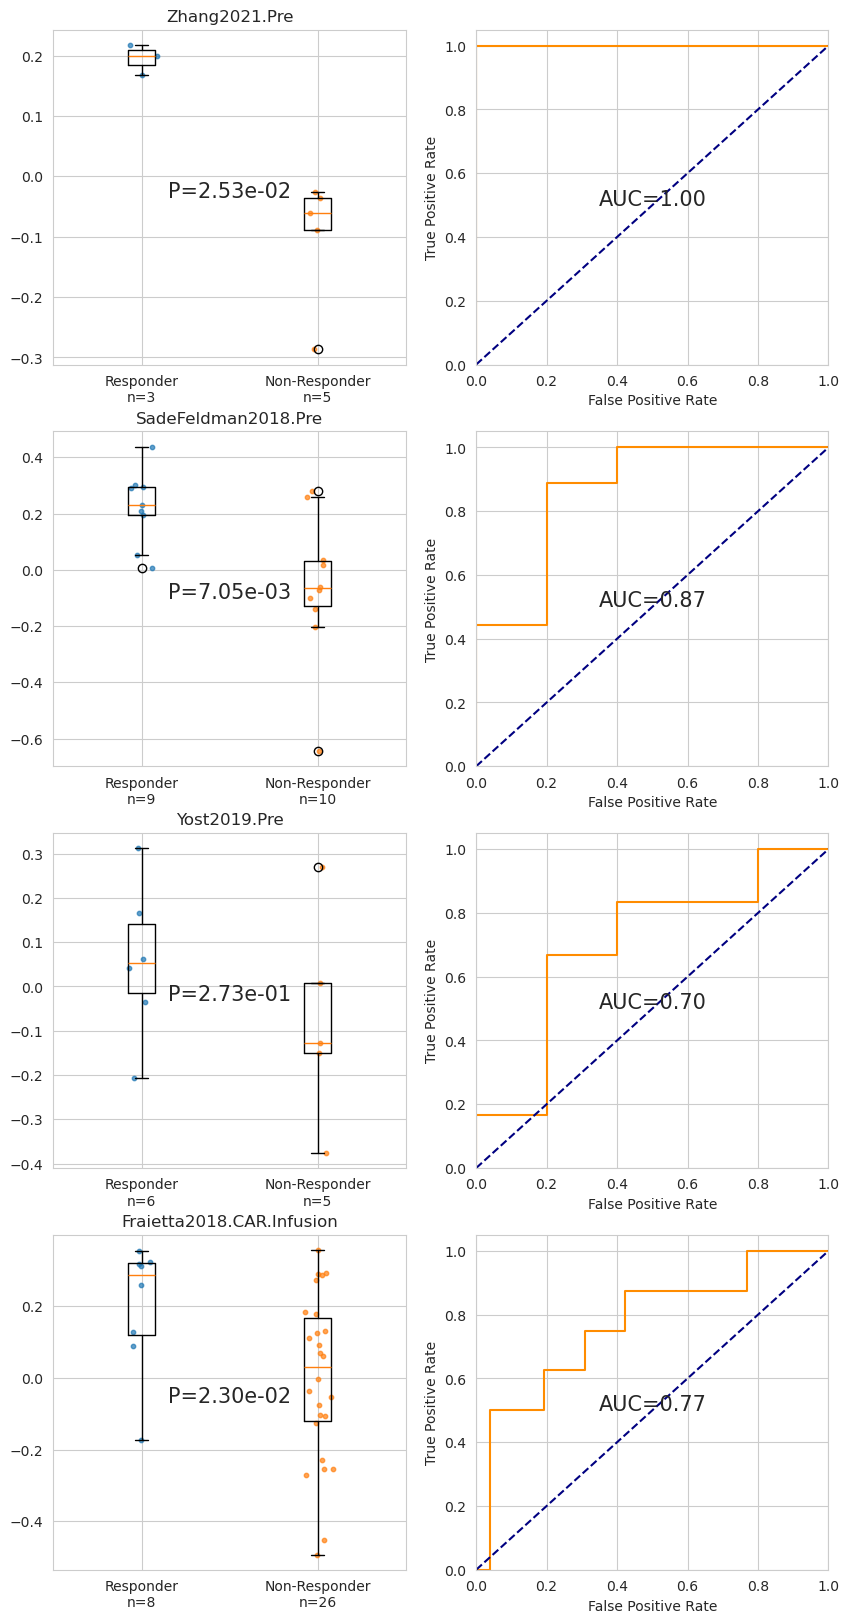

In [11]:
dataset_list = ["Zhang2021", "SadeFeldman2018", "Yost2019", "Fraietta2018"]
state_list = ['Pre', "Pre", "Pre", "CAR.Infusion"]

fig = plt.figure(figsize=(10, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=2, width_ratios=[1, 1])
for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    state = state_list[i]

    correlation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/3.CD8T_analysis/{dataset}.correlation.csv'
    sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/3.CD8T_analysis/{dataset}/{dataset}.sample_annotation.txt'

    if dataset == 'Zhang2021':
        bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/Atezolizumab+Paclitaxel_Pre_Zhang2021_TNBC.csv'
    elif dataset == 'SadeFeldman2018':
        bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/ICB_Pre_SadeFeldman2018_Melanoma.csv'
    elif dataset == 'Yost2019':
        bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/anti-PD1_Pre_Yost2019_BCC.csv'
    elif dataset == 'Fraietta2018':
        bulk_profile_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/test/data/CD19CAR_Infusion.CAR_Fraietta2018_CLL.csv'
    bulk_profile_df = pd.read_csv(bulk_profile_path, index_col=0)

    correlation_df = pd.read_csv(correlation_path, header=0, index_col=0)
    sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)

    # filter the Pre sample
    sample_list = sample_annotation_df.index.values.tolist()
    if dataset == 'Yost2019':
        pre_tcell = [col for col in sample_list if 'pre.tcell' in col]
        pre_tcell_patient = [col.split('.')[1] for col in pre_tcell]
        others = [x for x in sample_list if x not in pre_tcell]
        for sample in others:
            if sample.split('.')[1] in pre_tcell_patient:
                continue
            else:
                if 'pre' in sample:
                    pre_tcell.append(sample)
        sample_list = pre_tcell

    if dataset != 'Fraietta2018':
        sample_list = [sample for sample in sample_list if state.lower() in sample.lower()]
        sample_annotation_df = sample_annotation_df.loc[sample_list]

    # response_correlation = correlation_df.loc[sample_annotation_df[sample_annotation_df['response'] == 'R'].index]
    # nonresponse_correlation = correlation_df.loc[sample_annotation_df[sample_annotation_df['response'] == 'NR'].index]

    response_correlation = correlation_df.loc[[col for col in bulk_profile_df.columns if 'True' in col]]
    nonresponse_correlation = correlation_df.loc[[col for col in bulk_profile_df.columns if 'False' in col]]

    correlation_data = [np.array(response_correlation).ravel(), np.array(nonresponse_correlation).ravel()]
    p_value = ranksums(response_correlation, nonresponse_correlation).pvalue
    p_value_format = format(p_value[0], '0.2e')

    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])

    ax1.boxplot(correlation_data)
    # add scatter
    for i in range(len(correlation_data)):
        y = correlation_data[i]
        x = np.random.normal(i + 1, 0.04, size=len(y))
        ax1.scatter(x, y, alpha=0.7, s=10)
    y_mean = (max(max(row) for row in correlation_data) + min(min(row) for row in correlation_data)) / 2
    ax1.text(1.5, y_mean, f'P={p_value_format}', ha='center', fontsize=15)
    ax1.set_xticks([1, 2])
    ax1.set_xticklabels([f'Responder\nn={len(response_correlation)}', f'Non-Responder\nn={len(nonresponse_correlation)}'])

    # calculate ROC
    y_true = [1] * len(response_correlation) + [0] * len(nonresponse_correlation)
    y_pred = list(correlation_data[0]) + list(correlation_data[1])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax2.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc})')
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax2.text(0.5, 0.5, f'AUC={"{:.2f}".format(roc_auc)}', ha='center', fontsize=15)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')

    ax1.set_title(f'{dataset}.{state}')
plt.show()